In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D



sns.set()

In [2]:
folder = "ae_clusters"

In [33]:
datafile="data/{}/clusters_4_hidden_states.csv".format(folder)
data = pd.read_csv(datafile, dtype=np.float32)
data = data.drop(data[data.DX_mask == 0].index)
#data = data.dropna(subset=["DXCHANGE"])
#data.DXCHANGE = data.DXCHANGE.astype(int)

#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE > 3, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE < 4, 1)
x = data.iloc[:,4:132]
x

,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,hidden_6,hidden_7,hidden_8,hidden_9,...,hidden_118,hidden_119,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127
0,-0.002100,-0.002938,-0.022391,0.911125,0.434736,-0.000753,-0.387375,0.739522,0.215991,0.000133,...,-0.229895,0.008365,0.240203,-0.163388,-0.317138,-0.091177,-0.476269,-0.662892,0.073879,-0.051158
1,-0.002858,-0.004200,-0.023653,0.811505,-0.766166,-0.000834,0.647257,-0.474555,0.293579,0.000140,...,-0.689005,0.013261,0.319534,-0.265880,-0.451110,-0.133271,-0.414103,-0.589543,0.082297,-0.064725
2,-0.004264,-0.006450,-0.027043,0.755668,-0.746437,-0.000972,0.090867,-0.519289,0.356609,0.000147,...,-0.771652,0.025557,0.521280,-0.317481,-0.580755,-0.240572,-0.851654,-0.867885,0.105980,-0.083434
3,-0.048701,-0.034945,-0.372725,-0.899315,0.014465,0.994461,-0.739306,0.147014,0.028417,0.021646,...,-0.364853,-0.036839,-0.143676,0.947873,0.064149,-0.063529,0.000646,0.189537,-0.153156,-0.839098
4,-0.051738,-0.037658,-0.499609,-0.753125,0.023042,0.988964,-0.540676,0.093098,0.033430,0.024097,...,-0.517530,-0.040424,-0.164102,0.912762,-0.015892,-0.074090,0.000908,0.301661,-0.062995,-0.651165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,-0.090292,0.543470,0.692284,-0.736735,0.032252,0.139099,0.288430,-0.110911,-0.187702,-0.418384,...,-0.167045,-0.606344,0.019546,0.239370,0.174755,-0.134260,0.023700,0.000083,-0.202329,0.889965
5725,-0.102177,0.222017,0.889520,-0.775754,0.082412,0.270148,0.777339,-0.288726,-0.417258,-0.145481,...,-0.386235,-0.808698,0.047172,0.094611,0.153804,-0.253020,0.078990,0.000150,-0.330529,0.833909
5726,-0.719618,-0.104676,-0.070028,-0.403629,0.033827,-0.039821,-0.456147,-0.348892,0.584242,-0.229742,...,-0.771533,-0.956640,-0.474906,0.984374,0.765342,-0.037561,0.015203,0.000089,-0.002741,0.565938
5727,-0.104628,0.176834,-0.508596,-0.994776,-0.000878,0.703805,-0.914513,-0.803985,0.977497,0.798165,...,-0.560238,-0.624870,-0.000902,0.957951,-0.561775,-0.204715,0.001345,0.004590,0.241469,0.640382


In [12]:
"""
This method clusters hidden states independently of any classification task
This is just to extract the data from the latent space and perform visualizations
"""
def cluster(hidden_states, n_prototypes, hidden_size=128, extra_fields=["DXCHANGE"]):
    model = KMeans(n_clusters=n_prototypes, init="k-means++")
    batch_x = pd.read_csv(hidden_states)
    batch_x = batch_x.drop(batch_x[batch_x.DX_mask == 0].index)
    batch_x = batch_x.dropna(subset=["DXCHANGE"])
    batch_x.DXCHANGE = batch_x.DXCHANGE.astype(int)
    hiddens = batch_x.to_numpy()[:,4:4+hidden_size]
    model.fit(hiddens)
    batch_x["cluster"] = model.labels_
    return batch_x, model

In [13]:
def _parallel_compute_distance(x, cluster):
    n_samples = x.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((x.iloc[i] - cluster) ** 2, axis=0))
    return dis_mat

In [14]:
def get_prototypes(model, n_prototypes, batch_x, hidden_size = 128):
    centers = model.cluster_centers_
    prototype_list = [None]*n_prototypes
    for pr in range(n_prototypes):
        # Only get time points that exist (not imputed values, check cat mask)
        mask = (np.array(model.labels_) == pr)
        assigned = batch_x[mask]
        #print("assigned {}".format(assigned.iloc[:, 4:4+hidden_size]))
        #print("prototype {}".format(centers[pr]))
        dist_mat = _parallel_compute_distance(assigned.iloc[:, 4:4+hidden_size], centers[pr])
        #print(dist_mat)
        closest_dp = np.argmin(dist_mat)
        rid = assigned.iloc[closest_dp, 0]
        tp = assigned.iloc[closest_dp, 1]
        hidden = assigned.iloc[closest_dp, 2:]
        prototype_list[pr] = [int(rid), int(tp), hidden]
    prototype_hidden = (tup[2] for tup in prototype_list)
    prototype_hidden = np.vstack(prototype_hidden)
    prototype_hidden = np.array(prototype_hidden)
    return prototype_list

In [15]:
mapping = {
    0:"No Change",
    1:"CN",
    2:"MCI",
    3:"AD",
    4:"CN-MCI",
    5:"MCI-AD",
    6:"CN-AD",
    7:"MCI-CN",
    8:"AD-MCI"
}

In [34]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(x.values)
pca_result = pd.DataFrame({"PCA-0":pca_result[:,0], "PCA-1":pca_result[:,1], "PCA-2":pca_result[:,2]})

pca_result = pd.concat([data, pca_result], axis=1)
#pca_result = pca_result.drop(columns=["index"])
pca_result

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,Clusters,DXCHANGE,PCA-0,PCA-1,PCA-2
0,3.0,6.0,2.0,1.0,-0.002100,-0.002938,-0.022391,0.911125,0.434736,-0.000753,...,-0.091177,-0.476269,-0.662892,0.073879,-0.051158,3.0,NaN,2.358819,2.164316,1.951755
1,3.0,12.0,2.0,1.0,-0.002858,-0.004200,-0.023653,0.811505,-0.766166,-0.000834,...,-0.133271,-0.414103,-0.589543,0.082297,-0.064725,3.0,NaN,2.685401,2.552197,1.684586
2,3.0,24.0,2.0,1.0,-0.004264,-0.006450,-0.027043,0.755668,-0.746437,-0.000972,...,-0.240572,-0.851654,-0.867885,0.105980,-0.083434,3.0,NaN,3.306450,3.303607,1.824083
3,4.0,6.0,1.0,1.0,-0.048701,-0.034945,-0.372725,-0.899315,0.014465,0.994461,...,-0.063529,0.000646,0.189537,-0.153156,-0.839098,0.0,NaN,0.109148,-2.549892,1.361256
4,4.0,12.0,1.0,1.0,-0.051738,-0.037658,-0.499609,-0.753125,0.023042,0.988964,...,-0.074090,0.000908,0.301661,-0.062995,-0.651165,0.0,NaN,0.110229,-2.470596,1.606652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,5292.0,6.0,0.0,1.0,-0.090292,0.543470,0.692284,-0.736735,0.032252,0.139099,...,-0.134260,0.023700,0.000083,-0.202329,0.889965,2.0,NaN,-3.397787,2.708388,-1.082506
5725,5292.0,24.0,0.0,1.0,-0.102177,0.222017,0.889520,-0.775754,0.082412,0.270148,...,-0.253020,0.078990,0.000150,-0.330529,0.833909,2.0,NaN,-3.236799,2.560335,-1.860901
5726,5294.0,24.0,0.0,1.0,-0.719618,-0.104676,-0.070028,-0.403629,0.033827,-0.039821,...,-0.037561,0.015203,0.000089,-0.002741,0.565938,2.0,NaN,-4.419277,2.087214,1.011189
5727,5295.0,24.0,0.0,1.0,-0.104628,0.176834,-0.508596,-0.994776,-0.000878,0.703805,...,-0.204715,0.001345,0.004590,0.241469,0.640382,2.0,NaN,-2.367604,2.166637,-0.180354


         RID    TP   DX  DX_mask  hidden_0  hidden_1  hidden_2  hidden_3  \
3696  2347.0  12.0  1.0      1.0 -0.656857  0.017829 -0.605572 -0.305912   

      hidden_4  hidden_5  ...  hidden_123  hidden_124  hidden_125  hidden_126  \
3696  0.013454  0.989268  ...    0.095403    0.002294    0.007121    0.114983   

      hidden_127  Clusters  DXCHANGE     PCA-0     PCA-1    PCA-2  
3696   -0.679883         0       NaN -1.277229 -2.800327  2.06527  

[1 rows x 137 columns]
       RID   TP   DX  DX_mask  hidden_0  hidden_1  hidden_2  hidden_3  \
525  187.0  6.0  1.0      1.0 -0.019508 -0.006566  0.009822  0.480614   

     hidden_4  hidden_5  ...  hidden_123  hidden_124  hidden_125  hidden_126  \
525  0.012651  0.998194  ...   -0.068963    0.024921    0.474813   -0.177327   

     hidden_127  Clusters  DXCHANGE     PCA-0     PCA-1     PCA-2  
525    -0.28298         1       NaN  1.443696 -2.808856 -1.329143  

[1 rows x 137 columns]
      RID    TP   DX  DX_mask  hidden_0  hidden_1  hidde

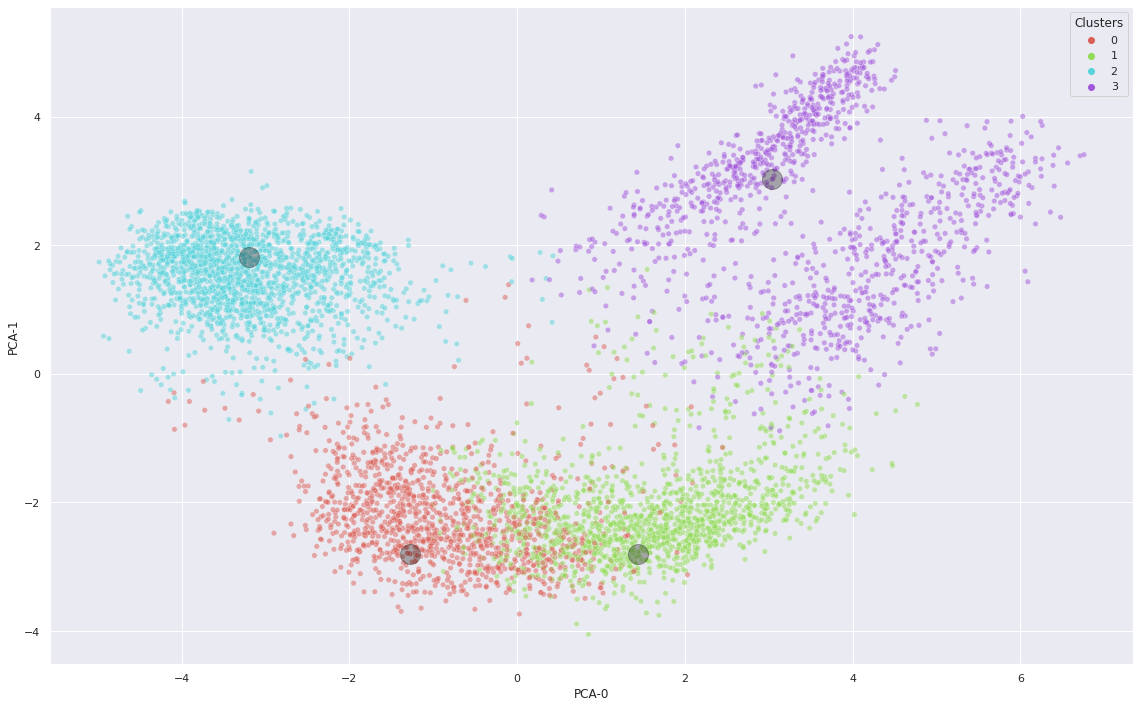

In [35]:
#full_pca_result = pca_result.replace({"DXCHANGE":mapping})
pca_result.Clusters = pca_result.Clusters.astype(int)
plt.figure(figsize=(16,10))
color = "Clusters"
n_clusters=4
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue=color,  
    #style="PTGENDER",
    s = 30,
    palette=sns.color_palette("hls", n_clusters),
    data=pca_result,
    legend="full",
    alpha=0.5
)
#prototypes=[[23, 6], [116, 6],[554, 6],[4653, 12],[919, 18],[4372, 12],[4167, 36],[303, 36],[1033, 12],[5242, 6],[816, 12],[995, 18],[47, 6],[4659, 6],[1315, 6]]
prototypes = [[2347, 12],[187, 6],[48, 12],[853, 6]]
for i in range(n_clusters):
    point = pca_result[(pca_result.RID == prototypes[i][0]) & (pca_result.TP == prototypes[i][1])]
    print(point)
    pca0=point.iloc[0,-3]
    pca1=point.iloc[0,-2]
    ax.plot([pca0], [pca1], color="black",marker="o", markersize=20, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/results/{}_hidden_states_pca_color_{}_all_{}_clusters.png".format(folder,color,n_clusters))

In [107]:
ticks = ax.get_xlim()
xstart, xend = (ticks[0],ticks[-1])
ticks = ax.get_ylim()
ystart, yend = (ticks[0],ticks[-1])

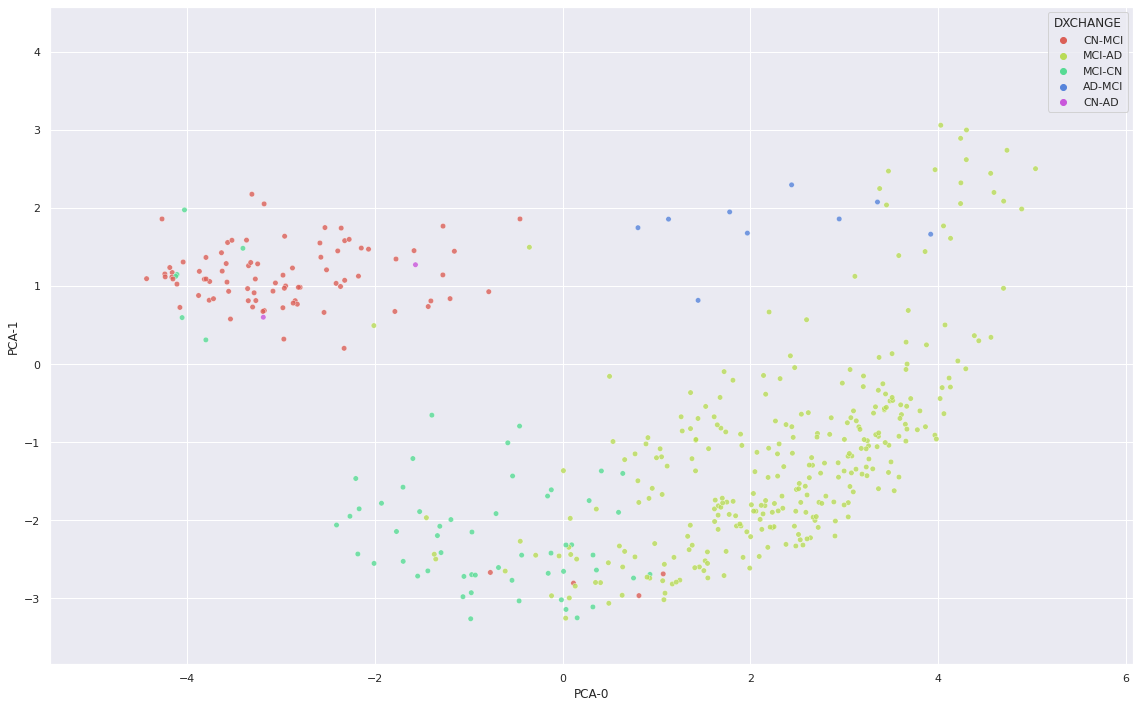

In [110]:
pca_result_ad = pca_result.copy()
#pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE != 5)), 3)
pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE >3)), 0)
pca_result_ad = pca_result_ad.drop(pca_result_ad[pca_result_ad.DXCHANGE == 0].index)
pca_result_ad = pca_result_ad.replace({"DXCHANGE":mapping})

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="DXCHANGE",  
    #style="PTGENDER",
    s = 30,
    palette=sns.color_palette("hls", 15),
    data=pca_result_ad,
    legend="full",
    alpha=0.8
)
plt.xlim([xstart,xend])
plt.ylim([ystart,yend])
plt.tight_layout()

plt.savefig("figures/results/classifier_hidden_states_pca_color_{}.png".format(color))

In [113]:
pca_result_mci_ad_transitioners = pca_result.copy()
pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.where(pca_result_mci_ad_transitioners.DXCHANGE == 5, 0)
pca_result_mci_ad_transitioners = pca_result_mci_ad_transitioners.drop(pca_result_mci_ad_transitioners[pca_result_mci_ad_transitioners.DXCHANGE == 0].index)


pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.map(mapping)
pca_result_mci_ad_transitioners

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,cluster,DXCHANGE,PCA-0,PCA-1,PCA-2
56,30.0,6.0,2.0,1.0,0.509573,0.003358,-0.206600,-0.227967,0.373774,-0.015723,...,0.257633,-0.073832,0.161207,0.143899,0.795335,3,MCI-AD,0.909911,-0.941816,-2.063610
68,42.0,12.0,2.0,1.0,0.736114,0.008294,-0.408027,-0.485327,0.076179,0.020427,...,-0.139805,-0.039580,0.094994,0.449341,0.256196,0,MCI-AD,1.067145,-2.773516,0.681130
85,45.0,12.0,2.0,1.0,0.751413,0.145757,-0.153273,-0.495200,0.125678,-0.549045,...,0.234207,0.018846,0.265597,-0.066915,0.673511,4,MCI-AD,2.791647,-1.267466,-0.568580
95,50.0,6.0,2.0,1.0,0.511012,0.070068,0.154817,-0.235739,0.070040,-0.429950,...,-0.008186,-0.013018,0.176227,0.180326,0.635159,4,MCI-AD,2.164712,-0.385931,-0.365913
111,54.0,12.0,2.0,1.0,0.568860,0.256198,0.537810,-0.415220,0.143738,-0.782953,...,0.127968,0.002904,0.498272,0.098997,0.739834,4,MCI-AD,4.075981,0.500849,-0.034115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,4947.0,24.0,2.0,1.0,0.815448,0.132079,-0.141792,-0.376233,-0.098562,-0.194142,...,-0.184079,-0.105488,0.049084,0.381050,0.671749,4,MCI-AD,2.212728,-2.086818,-0.415933
5385,4958.0,6.0,2.0,1.0,0.442142,0.015768,-0.312100,-0.230964,-0.251859,-0.117083,...,0.301548,0.045779,0.058230,-0.061901,0.637345,5,MCI-AD,0.662127,-1.223161,-0.873722
5454,5026.0,12.0,2.0,1.0,0.732187,0.054492,-0.253715,-0.246801,-0.268925,-0.080633,...,0.080867,-0.071988,-0.085019,0.471340,-0.296633,0,MCI-AD,0.360207,-1.856238,1.987150
5463,5031.0,24.0,2.0,1.0,0.786354,0.045003,-0.408316,-0.414799,-0.011256,-0.539360,...,-0.005543,0.059849,0.186380,0.046284,0.610984,4,MCI-AD,2.703713,-1.952164,0.141045


In [114]:
pca.explained_variance_ratio_

array([0.49355483, 0.28787894, 0.04983424, 0.03021677])

In [138]:
n_clusters = 4
model = KMeans(n_clusters=n_clusters, init="k-means++", random_state=12)
x = pca_result_mci_ad_transitioners.iloc[:,4:4+128]
model.fit(x)
pca_result_mci_ad_transitioners["cluster"] = model.labels_
pca_result_mci_ad_transitioners.DXCHANGE = 5
prototypes = get_prototypes(model, n_clusters, pca_result_mci_ad_transitioners)
prototypes
for i, p in enumerate(prototypes):    
    mask = pca_result_mci_ad_transitioners.cluster == i
    c = pca_result_mci_ad_transitioners[mask]
    c.to_csv("results/mci_ad_transitioners_{}_cluster_all_{}_{}_{}.csv".format(n_clusters, i, prototypes[i][0], prototypes[i][1]))
prototype_ids = [[rid, tp] for (rid, tp, feat) in prototypes]
prototype_ids

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[[195, 12], [4502, 12], [344, 12], [179, 18]]

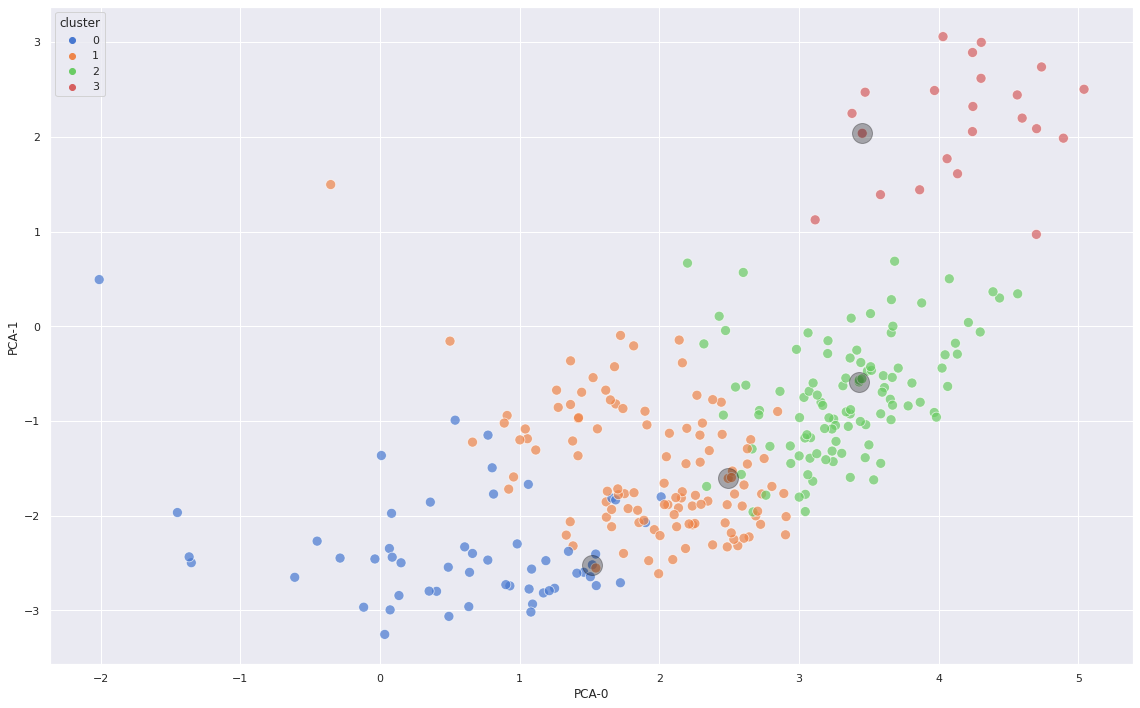

In [142]:
mapping = {
    0:0,
    1:3,
    2:1,
    3:2
}
pca_result_mci_ad_transitioners = pca_result_mci_ad_transitioners.replace({"cluster":mapping})
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="cluster",  
    s = 100,
    palette="muted",
    data=pca_result_mci_ad_transitioners,
    legend="full",
    alpha=0.7
)
for i in range(n_clusters):    
    ax.plot([prototypes[i][2][-3]], [prototypes[i][2][-2]], color="black",marker="o", markersize=20, alpha=0.3)
#ax.get_legend().remove()
plt.tight_layout()
plt.savefig("figures/results/classifier_pca_color_cluster_mci_ad_clustering_{}_all.png".format(n_clusters))


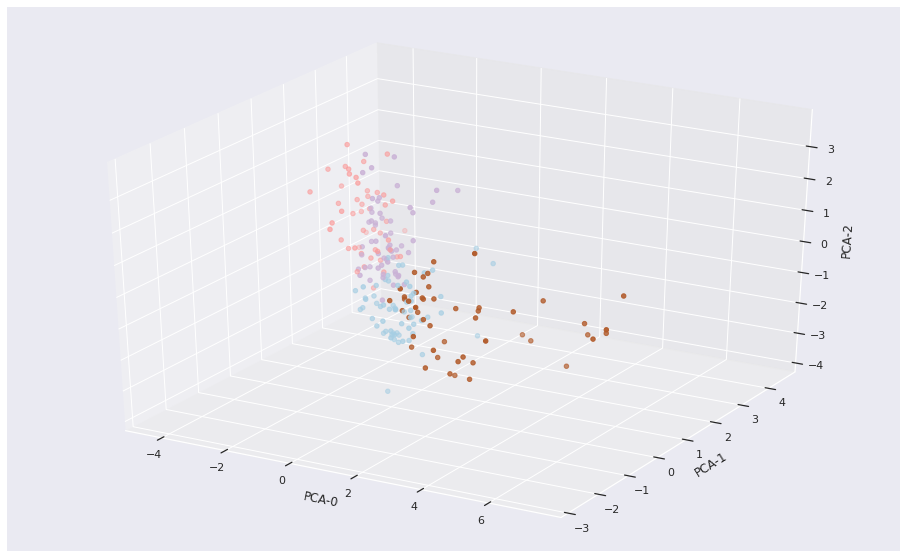

In [161]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result_mci_ad_transitioners["PCA-0"],
    ys=pca_result_mci_ad_transitioners["PCA-1"],
    zs=pca_result_mci_ad_transitioners["PCA-2"],
    c=pca_result_mci_ad_transitioners["cluster"], 
    cmap='Paired'
)
ax.set_xlabel('PCA-0')
ax.set_ylabel('PCA-1')
ax.set_zlabel('PCA-2')
plt.savefig("figures/{}/hidden_states_pca_color_cluster_mci_ad_transitioners_4_3d.png".format(folder))